# Data Preprocessing and model initialization

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Loading Dataset
train_dataset = load_dataset("ag_news", split = "train")
valid_dataset = load_dataset("ag_news", split="test")

# Loading Pretrained Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)


# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization to datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

# **Disabling WANDB**

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Start Training Pipeline

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",                  # Or "steps" if you prefer
    save_strategy="epoch",                  # Save every epoch
    load_best_model_at_end=True,            # Keep only the best model
    metric_for_best_model="eval_loss",      # Based on loss
    greater_is_better=False,                # Because lower loss = better
    save_total_limit=1,                     # Keep only best checkpoint
    logging_dir="./logs",
    report_to="none",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    save_steps=100,          # save every N steps
)

from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Saving Checkpoint

In [ ]:
import shutil

# Define the folder and output zip path
checkpoint_dir = "/kaggle/working/results/checkpoint-3750"
output_zip = "/kaggle/working/results/checkpoint-3750_backup.zip"

# Zip the folder
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=checkpoint_dir)

print(f"Checkpoint zipped and saved to: {output_zip}")


# Continuing training from checkpoint

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",           # Corrected key from `eval_strategy`
    save_strategy="epoch",                 # Save after every epoch
    load_best_model_at_end=True,           # Load best based on eval_loss
    metric_for_best_model="eval_loss",     # Based on eval_loss
    greater_is_better=False,               # Because lower loss is better
    save_total_limit=1,                    # Keep only 1 best checkpoint
    logging_dir="./logs",
    logging_steps=500,                     # Show logs every 500 steps
    report_to="none",                      # No W&B or TensorBoard logging
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    save_steps=100                         # Optional: if you still want to save every 100 steps
)

# Accuracy metric
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Continue training from last checkpoint if exists
trainer.train(resume_from_checkpoint="/kaggle/input/bert-v1/transformers/default/1")

# Testing and Confusion Matrix

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


              precision    recall  f1-score   support

       World       0.97      0.94      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.90      0.91      1900
    Sci/Tech       0.89      0.95      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.95      0.94      0.94      7600
weighted avg       0.95      0.94      0.94      7600



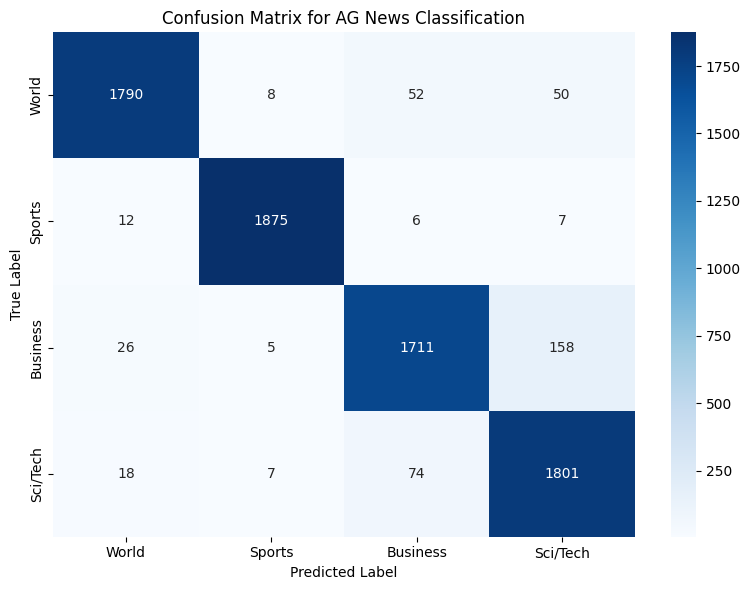

In [3]:
import torch, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
warnings.filterwarnings("ignore")

# === 1. Load the trained model checkpoint ===
checkpoint_path = "/kaggle/input/bert_ag_news/transformers/default/1"  
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# === 2. Load and tokenize the validation dataset ===
valid_dataset = load_dataset("ag_news", split="test")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

valid_dataset = valid_dataset.map(tokenize_function, batched=True)
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# === 3. Use Hugging Face Trainer to predict ===
trainer = Trainer(model=model)
predictions = trainer.predict(valid_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# === 4. Label mapping and report ===
class_names = ["World", "Sports", "Business", "Sci/Tech"]
print(classification_report(true_labels, pred_labels, target_names=class_names))

# === 5. Confusion Matrix ===
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for AG News Classification")
plt.tight_layout()

# === 6. Save the confusion matrix image ===
plt.savefig("confusion_matrix_ag_news.png", dpi=300)
plt.show()

# Hugging Face TO ONNX

In [ ]:
pip install optimum[exporters]
!optimum-cli export onnx --model /kaggle/input/bert_ag_news/transformers/default/1 --task text-classification /kaggle/working/

# Inference on ONNX

In [14]:
import onnxruntime
from transformers import AutoTokenizer
import numpy as np
import torch.nn.functional as F

# AG News class labels
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Load tokenizer from local export directory
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/") # Change Path to provided Tokenize

# Load ONNX model
session = onnxruntime.InferenceSession("/kaggle/working/model.onnx") # Path to onnx model file

# Sample input text
text = "Google shares rose after earnings beat expectations." # Test Input 

# Tokenize input
inputs = tokenizer(text, return_tensors="np", padding="max_length", truncation=True, max_length=128)

# Prepare ONNX inputs (convert to int64)
onnx_inputs = {k: v.astype(np.int64) for k, v in inputs.items()}

# Run inference
logits = session.run(None, onnx_inputs)[0]

# Apply softmax to get probabilities
probs = F.softmax(torch.tensor(logits), dim=1).numpy()
predicted_class = int(np.argmax(probs))

# Output
print("Predicted class index:", predicted_class)
print("Predicted label:", label_map[predicted_class])

Predicted class index: 3
Predicted label: Sci/Tech
